# Custom ODE (with additional input arguments) Data Generation

The insidapy package can also be used together with custom ODE files to quickly generate different datasets. The following example shows how to use the `custom_ode` class to generate data from such an ODE file. 

This particular notebook explains how to use the codes in case the separete ODE file has additional input arguments (i.e., it is a function of the form func(t,x,args)). In case there are NO additional arguments, check out the notebook `main_custom_ode_without_arguments.ipynb`.

First, the `custom_ode` class is loaded:

In [19]:
from insidapy.simulate.ode import custom_ode

Then, the user can define where the separate file with the ODE system is located. The relative path and the filename of the separate function file need to be given as a string. Additionally, the name of the function in the given function file needs to be indicated:

In [20]:
CUSTOM_ODE_RELATIVE_PATH = '.'
CUSTOM_ODE_FILENAME = 'customodefile_with_args'
CUSTOM_ODE_FUNC_NAME = 'customode'

Additionally, the user can either add additional parameters that should be passed to the function file by using the `ode_arguments` input or not. The following example shows the case where additional parameters are passed to the ODE file. The separate ODE file is located in `docs/notebooks/customodefile_with_args`:

In [21]:
# Give information about the ODE system
CUSTOM_ODE_SPECIES = ['A', 'B', 'C']
CUSTOM_ODE_TSPAN = [0, 3]
CUSTOM_ODE_BOUNDS_INITIAL_CONDITIONS = [[2, 0, 0], [3, 1, 0]]
CUSTOM_ODE_ARGUMENTS = {'k1': 2, 'k2': 1, 'k3': 3}

# Define the units of the ODE system
CUSTOM_ODE_NAME_OF_TIME_UNIT = 'hours'
CUSTOM_ODE_NAME_OF_SPECIES_UNITS = ['g/L', 'g/L', 'g/L']

The separate ODE file could look for example like this (given in markdown format, for the file, check it at `docs/notebooks/customodefile_with_args.py`):

```python
import numpy as np
def customode(t, y, coefs):
    """Custom ODE system. A batch reactor is modeled with two species. The following system
    is implemented: A <-[k1],[k2]-> B -[k3]-> C

    Args:
        y (array): Concentration of species of shape [n,].
        t (scalar): time.
        coefs (dict): Dictionary of coefficients or other information.

    Returns:
        array: dydt - Derivative of the species of shape [n,].
    """

    # Variables  
    A = y[0]
    B = y[1]
    C = y[2]

    # Parameters
    k1 = coefs['k1']
    k2 = coefs['k2']
    k3 = coefs['k3']    

    # Rate expressions
    dAdt = k2*B - k1*A
    dBdt = k1*A - k2*B - k3*B
    dCdt = k3*B

    # Vectorization
    dydt = np.array((dAdt, dBdt, dCdt))

    # Return
    return dydt.reshape(-1,)
```

Similar to the `batch`-class example above, the instance is created (in case no additional arguments should be passed to the separate ODE function, just ommit the parameter `ode_arguments` and create the separate function file only by `def ODE(t,y)`):

In [22]:
data = custom_ode(  filename_custom_ode=CUSTOM_ODE_FILENAME,                        # REQUIRED: Filename of the file containing the ODE system.
                    relative_path_custom_ode=CUSTOM_ODE_RELATIVE_PATH,              # REQUIRED: Relative path to the file containing the ODE system.
                    custom_ode_function_name=CUSTOM_ODE_FUNC_NAME,                  # REQUIRED: Name of the ODE function in the file.
                    species=CUSTOM_ODE_SPECIES,                                     # REQUIRED: List of species.
                    bounds_initial_conditions=CUSTOM_ODE_BOUNDS_INITIAL_CONDITIONS, # REQUIRED: Bounds for initial conditions.
                    time_span=CUSTOM_ODE_TSPAN,                                     # REQUIRED: Time span for integration.
                    ode_arguments=CUSTOM_ODE_ARGUMENTS,                             # OPTIONAL: Arguments of the ODE system. Defaults to "None".
                    name_of_time_unit=CUSTOM_ODE_NAME_OF_TIME_UNIT,                 # OPTIONAL: Name of time unit. Defaults to "h".
                    name_of_species_units=CUSTOM_ODE_NAME_OF_SPECIES_UNITS,         # OPTIONAL: Name of species unit. Defaults to "g/L".
                    nbatches=3,                                                     # OPTIONAL: Number of batches. Defaults to 1.
                    npoints_per_batch=50,                                           # OPTIONAL: Number of points per batch and per species. Defaults to 50.
                    noise_mode='percentage',                                        # OPTIONAL: Noise mode. Defaults to "percentage".
                    noise_percentage=2.5,                                           # OPTIONAL: Noise percentage (in case mode is "percentage"). Defaults to 5%.      
                    random_seed=0,                                                  # OPTIONAL: Random seed for reproducibility. Defaults to 0.
                    initial_condition_generation_method='LHS',                      # OPTIONAL: Method for generating initial conditions. Defaults to "LHS".
                    name_of_time_vector='time')                                     # OPTIONAL: Name of time vector. Defaults to "time".

[!] IMPORTANT: It seems that you changed the default bounds of the species. Make sure the order of the indicated bounds is the following: ['A', 'B', 'C']


After this preparation work, we can run the experiments to create some in-silico data using the `run_experiments` method. We can then for example check the data of the first experiment.

In [23]:
data.run_experiments()

[+] Experiments done.


As in the `batch` class, the generated data can be plotted:

[+] Saving figure:
	->png: .\figures\custom_odes_with_args.png


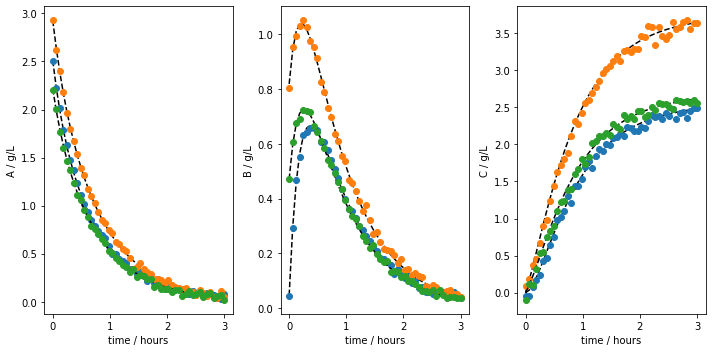

In [24]:
data.plot_experiments(  show=True,
                        save=True, 
                        figname='custom_odes_with_args', 
                        save_figure_directory=r'.\figures', 
                        save_figure_exensions=['png'])

Most modeling approaches require a training dataset and a separate testing dataset. To generate separate datasets, the user can apply a splitting in an sklearn-manner. There is no default value set. In case the user calls the function, a `test_splitratio` in the range [0,1) needs to be chosen. The value represents the fraction of the total number of batches generated used for the test set. The data is then splitted and stored in the data object as `data.training` and `data.testing`. 

In [25]:
data.train_test_split(test_splitratio=0.2)

We can now also plot the experiments while showing the training and testing runs individually. The method lets us save the figure using a path (`save_figure_directory`), a name (`figname`) and an some extensions (`save_figure_exensions`) as a list. By using `show=False`, the plot will not be displayed in a running code.

[+] Saving figure:
	->png: .\figures\custom_custom_ode_train_test.png


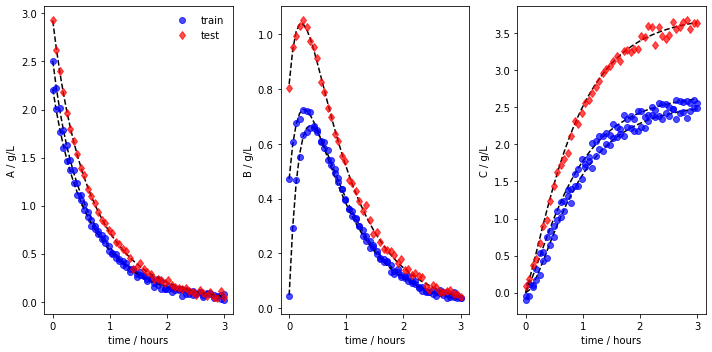

In [26]:
data.plot_train_test_experiments(   save=True, 
                                    show=False,
                                    figname=f'{data.example}_custom_ode_train_test',
                                    save_figure_directory=r'.\figures', 
                                    save_figure_exensions=['png'])

After the simulation, one can export the data as XLSX files. By choosing `which_dataset` to be `training` (only executable if `train_test_split` was applied), `testing` (only executable if `train_test_split` was applied), or `all` (always executable), the corresponding data is exported to the indicated location:

In [27]:
data.export_dict_data_to_excel(destination=r'.\data', which_dataset='all')      # Exports all the data
data.export_dict_data_to_excel(destination=r'.\data', which_dataset='training') # Exports the training data
data.export_dict_data_to_excel(destination=r'.\data', which_dataset='testing')  # Exports the training data

[+] Exported batch data to excel.
	-> Dataset: ALL (options: training, testing, all)
	-> Noise free data to: .\data\custom_all_batchdata.xlsx
	-> Noisy data to: .\data\custom_all_batchdata_noisy.xlsx
[+] Exported batch data to excel.
	-> Dataset: TRAINING (options: training, testing, all)
	-> Noise free data to: .\data\custom_training_batchdata.xlsx
	-> Noisy data to: .\data\custom_training_batchdata_noisy.xlsx
[+] Exported batch data to excel.
	-> Dataset: TESTING (options: training, testing, all)
	-> Noise free data to: .\data\custom_testing_batchdata.xlsx
	-> Noisy data to: .\data\custom_testing_batchdata_noisy.xlsx
